# Monte Carlo Methods in RL

We use the Blackjack example stated in the note to illustrate the Monte Carlo methods in RL.
In this notebook we are going to fix the strategy of the dealer so that Blackjack becomes a single-agent game. Firstly, we are going to present the policy evaluation through Monte Carli and then we are going to use off-policy MC Control algorithm to figure out the optimal policy of the player.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from collections import defaultdict
import pandas as pd
import math
from math import isclose

## Game Dynamics

When one makes the action to hit, he draws a card, all face cards are regarded as 10.

In [2]:
# Simulates card drawing
# Input: nothing
# Output: an integer as the card drawn
def draw_card():
    card = np.random.randint(1,14)
    # Ace is denoted as 1
    # Face cards work as 10
    if card in [11,12,13]:
        card = 10
    return card

At the beginning of the game, the player and the dealer draws two cards.

In [3]:
# Calculates the sum of initial cards
# Input: first two cards
# Output: an int value as the sum
def init_sum(card_1,card_2):
    # Blackjack (10 + A)
    if (card_1 == 1 and card_2 == 10) or (card_1 == 10 and card_2 == 1):
        return 21

    # Two aces (11 + 1)
    if card_1 == 1 and card_2 == 1:
        return 12

    # Normal cases, aces are always explained as 11
    if card_1 == 1:
        card_1 = 11
    if card_2 == 1:
        card_2 = 11
    return card_1 + card_2

We always need to check if the game ends given the states.

In [4]:
# Judge whether the game ends and set up reward
# Input: player and dealer's sum of cards
# Output: if the game has ended, reward for player (-1 for lose, 0 for draw, 1 for win)
def judge_end_reward(p_sum,d_sum):
    p_blackjack = False
    d_blackjack = False
    # Whether there's blackjack for both sides
    if p_sum == 21:
        p_blackjack = True
    if d_sum == 21:
        d_blackjack = True

    game_ended = True
    if p_blackjack and d_blackjack: # Draw
        return game_ended, 0
    if p_blackjack and not d_blackjack:
        return game_ended, 1
    if d_blackjack and not p_blackjack:
        return game_ended, -1 
    
    # No Blackjack
    if p_sum > 21:
        return game_ended, -1
    elif d_sum > 21:
        return game_ended, 1
    game_ended = False
    return game_ended, 0

The dealer always chooses to stick iff his state is no smaller than $17$, a conservative strategy.

In [5]:
# Dealer's policy is fixed
# Input: the state of dealer
# Output: the action, 0 for stand, 1 for hit
def d_strategy(d_sum):
    # Stand iff d_sum >= 17
    if d_sum >= 17:
        return 0
    return 1

The action of the player results in the state transition.

In [6]:
# Player's state transition
def transition(p_action,p_state,Verbose = False):
    # Stand
    if p_action == 0:
        return p_state
    # Hit
    next_p_state = p_state.copy()
    new_card = draw_card()
    if Verbose:
        print("draw new card: " + str(new_card))
    new_sum = p_state[0] + new_card
    if p_state[1] == 1 and new_sum > 21:
        # Has usable ace, exceeds 21, change the usable ace value to 1
        next_p_state[0] = new_sum - 10
        next_p_state[1] = 0
    elif new_card == 1 and p_state[1] == 0 and p_state[0] + 11 <= 21:
        # No usable ace, check if this ace is usable
        next_p_state[0] = p_state[0] + 11
        next_p_state[1] = 1
    elif new_card == 1 and p_state[1] == 0 and p_state[0] + 11 > 21:
        next_p_state[0] = p_state[0] + 1
    else:
        # new card is not ace and no usable ace
        next_p_state[0] = new_sum
    return next_p_state

The Blackjack simulator is built that produces MDP trajectories.
The output are three lists of the same length in row, one for state, one for action, one for reward.

In [7]:
# Simulates Blackjack acoording to player's strategy
# Output: three lists of states, actions, rewards
def simulate_blackjack(p_strategy, Verbose = False):
    # Three lists
    state_list = list()
    action_list = list()
    reward_list = list()

    # First draw two cards for player and dealer
    p_card_1 = draw_card()
    p_card_2 = draw_card()
    d_card_1 = draw_card()
    d_card_2 = draw_card()
    if Verbose:
        print("player card: " + str(p_card_1) + ', ' + str(p_card_2))
        print("dealer card: " + str(d_card_1) + ', ' + str(d_card_2))

    # Dealer should let the player know what the first card is as part of the state
    state_d = d_card_1
    # If the player has usable ace (1 for yes, 0 for no)
    state_u = int((p_card_1 == 1) or (p_card_2 == 1))    

    # Figure out initial sums
    p_sum = init_sum(p_card_1,p_card_2)
    d_sum = init_sum(d_card_1,d_card_2)
    
    # Organize state of player
    p_state = [p_sum,state_u,state_d]
    
    while p_state[0] < 12:
        # Draw card
        p_action = 1
        p_state = transition(p_action,p_state,Verbose)
    
    game_ended = False
    
    # Player's turn
    while not game_ended:
        # State
        state_list.append(p_state)
        if Verbose:
            print("player state is " + str(p_state))
        
        # Player makes decision
        p_action = p_strategy(p_state)
        action_list.append(p_action)
        if Verbose:
            print('player takes action ' + str(p_action))
            
        # Player's action results in state transition
        next_p_state = transition(p_action,p_state,Verbose)
        psum = next_p_state[0]
        if next_p_state == p_state: # Player Stand
            break
        else:
            p_state = next_p_state
        
        # Reward
        p_sum = p_state[0]
        game_ended, p_reward = judge_end_reward(p_sum,d_sum)
        reward_list.append(p_reward)
        if Verbose:
            print('player receives reward ' + str(p_reward))
        if game_ended:
            # If it's due to reaching 21, record the state (a legal state)
            if p_sum == 21:
                state_list.append(p_state)
                action_list.append(0)
            break
        
    
    # Dealer's turn
    d_usable_ace = int((d_card_1 == 1) or (d_card_2 == 1)) 
    d_state = [d_sum,d_usable_ace]
    while not game_ended:
        if Verbose:
            print("dealer state is " + str(d_state))
            
        # Dealer makes decision
        d_action = d_strategy(d_sum)
        if Verbose:
            print("dealer take action " + str(d_action))
        
        # Dealer's action results in his sum to change
        next_d_state = transition(d_action,d_state,Verbose)
        if next_d_state == d_state: # Dealer Stand
            break
        else:
            d_state = next_d_state
        
        # If it ends
        d_sum = next_d_state[0]
        game_ended, p_reward = judge_end_reward(p_sum,d_sum)
        if game_ended:
            reward_list.append(p_reward)
            if Verbose:
                print('player receives reward ' + str(p_reward))
            break
        
            
    # When both of them are not busted, judge again who wins
    if not game_ended:
        if p_sum < d_sum:
            p_reward = -1
        elif p_sum > d_sum:
            p_reward = 1
        else:
            p_reward = 0
        reward_list.append(p_reward)
        if Verbose:
            print('player receives reward ' + str(p_reward))
    
    return state_list,action_list,reward_list

Test the simulation function above.

In [8]:
# Let's test the simulation, with player taking random action
def p_rand_strategy(state):
    return np.random.randint(0,2)

state_list,action_list,reward_list = simulate_blackjack(p_rand_strategy, Verbose = True)
print(state_list,action_list,reward_list)

player card: 2, 10
dealer card: 4, 7
player state is [12, 0, 4]
player takes action 0
dealer state is [11, 0]
dealer take action 1
draw new card: 10
player receives reward -1
[[12, 0, 4]] [0] [-1]


## Estimate value function through Monte Carlo

Assume that the player is taking the policy which is to stand iff the state is $20$ or $21$, a risky policy denoted $\pi$.

In [9]:
# This function generates action based on policy and state
# Input: the state as 2-tuple
# Output: the action according to the policy
def p_risky_strategy(state):
    # Here the policy is that only sticks if p_sum is 20 or 21
    # Action 0 means stick and action 1 means hit
    p_sum = state[0]
    if p_sum in [20,21]:
        return 0
    return 1

In [10]:
# Let's test the simulation, with player taking random action
state_list,action_list,reward_list = simulate_blackjack(p_risky_strategy, Verbose = True)
print(state_list,action_list,reward_list)

player card: 5, 3
dealer card: 10, 4
draw new card: 10
player state is [18, 0, 10]
player takes action 1
draw new card: 4
player receives reward -1
[[18, 0, 10]] [1] [-1]


Let's do every-visit Monte Carlo to estimate $v_\pi$. This MDP does not have discount factor, i.e. $\gamma = 1$.

In [11]:
# First-visit MC to estimate state value function
# Input: number of samples generated
# Output: state value function
def v_est_MC(NUM_SAMPLE):

    # A dict to keep track of the return of different states
    state_return_dict = defaultdict(list)

    for _ in range(SAMPLE_NUM):
        # simulate
        state_list, action_list, reward_list = simulate_blackjack(p_risky_strategy)

        # Record everything into dictionary
        for state in state_list:
            # The last reward is always the return!\
            # Since only one of the rewards is nonzero and the return is simply the summation of rewards
            state_return_dict[tuple(state)].append(reward_list[-1])

    # Take an average for each list in the dict, store it in a matrix
    v_func = np.zeros((30,2,30))
    for state in state_return_dict.keys():
        return_lst = state_return_dict[tuple(state)]
        v_func[state[0],int(state[1]),state[2]] = np.mean(return_lst)

    # The first index is from 12 to 21, the third index is from 1 to 10
    v_func = v_func[12:22,:,1:11]

    return v_func

Let's plot the estimated state value function as a 3D surface.

In [12]:
# Fix Random seed
np.random.seed(42)
SAMPLE_NUM = 1000000
v_func = v_est_MC(SAMPLE_NUM)

Plot value function when there is usable ace.

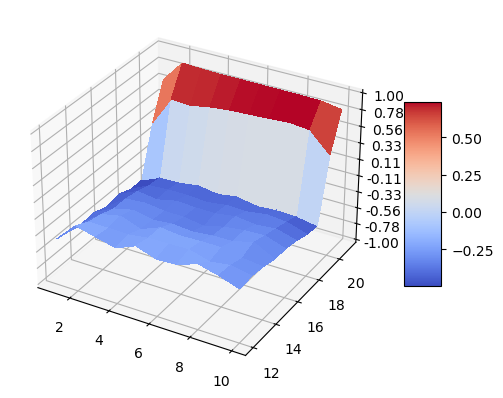

In [13]:
# Plot as 3D surface
p_sum = np.linspace(12,21,10)
d_card_1 = np.linspace(1,10,10)
d_card_1,p_sum = np.meshgrid(d_card_1,p_sum)
fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})

surf = ax.plot_surface(d_card_1,p_sum,v_func[:,1,:],cmap = cm.coolwarm, linewidth = 0, antialiased=False);

# Customize the z axis.
ax.set_zlim(-1, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.show()

Plot value function when there is no usable ace.

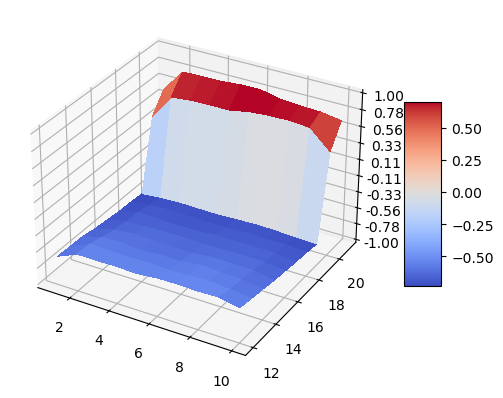

In [14]:
# Plot as 3D surface
p_sum = np.linspace(12,21,10)
d_card_1 = np.linspace(1,10,10)
d_card_1,p_sum = np.meshgrid(d_card_1,p_sum)
fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})

surf = ax.plot_surface(d_card_1,p_sum,v_func[:,0,:],cmap = cm.coolwarm, linewidth = 0, antialiased=False);

# Customize the z axis.
ax.set_zlim(-1, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.show()

## Solve Optimal Policy

We use the on-policy MC control method. For each MDP trajectory generated by $\pi$, collect return for each state-action pair, update the estimate for action value function and update $\pi$ as the greedy policy. We use $\varepsilon$-soft policy to encourage exploration.

In [15]:
# On-policy MC control with EPS-soft policy to solve optimal policy
def on_policy_MC_control():
    # Est for q, state dim (30,2,30), action dimension 2
    Q = np.zeros((30,2,30,2))
    EPS = 0.1
    
    # Initial Policy as hitting then sum <= 19 (EPS-soft)
    pi = np.zeros((30,2,30,2))
    pi[0:20,:,:,1] = (1 - EPS) * np.ones((20,2,30))
    pi[0:20,:,:,0] = EPS * np.ones((20,2,30))
    pi[20:30,:,:,0] = (1 - EPS) * np.ones((10,2,30))
    pi[20:30,:,:,1] = EPS * np.ones((10,2,30))
    
    # Dict of list storing return for state-action pair
    count_dict = defaultdict(int)
    
    while 1:
        # EPS-soft
        def pi_strategy(state):
            r = np.random.rand()
            if r < pi[state[0],state[1],state[2],0]:
                return 0
            else:
                return 1
        
        # Simulate
        state_list, action_list, reward_list = simulate_blackjack(pi_strategy)
        
        # Loop backward in time
        for t in range(len(state_list) - 1,-1,-1):
            s = state_list[t]
            a = action_list[t]
            if s[0] < 12:
                print(s)
            
            ret = reward_list[-1]
            count_dict[(s[0],s[1],s[2],a)] = count_dict.get((s[0],s[1],s[2],a),0) + 1
            count = count_dict[(s[0],s[1],s[2],a)]
            
            # Incremental Update
            Q[s[0],s[1],s[2],a] = (Q[s[0],s[1],s[2],a] * (count - 1) + ret) / count
            
            # Greedy policy EPS-soft
            best_action = np.argmax(Q[s[0],s[1],s[2],:])
            pi[s[0],s[1],s[2],best_action] = 1 - EPS
            pi[s[0],s[1],s[2],1 - best_action] = EPS
        
        # End loop only if enough exploration is done (each state-action pair has been visited
        # more than a given time)
        if np.min(list(count_dict.values())) >= 100:
            break
    # Return optimal deterministic policy
    return pi

Run this off-policy learning algorithm and plot the optimal policy.

In [16]:
np.random.seed(42)
opt_policy = on_policy_MC_control()

Notice that when the player's sum of cards reaches above a certain threshold, the optimal policy is always to stand, so we plot out that threshold for each state.

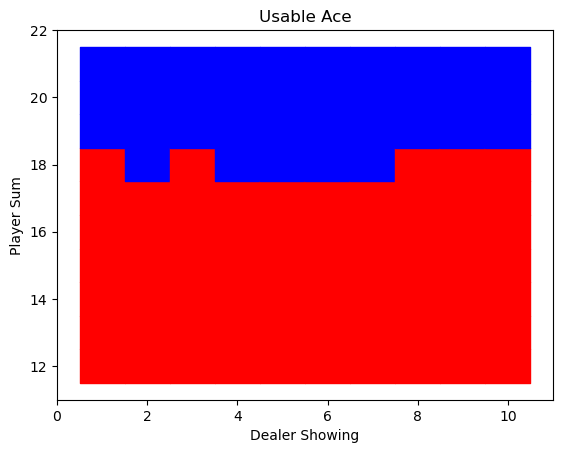

In [17]:
# The case when player has usable ace
for k in range(1,11):
    for i in range(12,22):
        # Check if it's legal
        if not isclose(opt_policy[i,1,k,0] + opt_policy[i,1,k,1],1):
            print("Not a legal policy!")
            break
        if np.abs(opt_policy[i,1,k,1] - 1) < 0.5:
            # Hit
            plt.fill_between(x = [k - 0.5, k + 0.5],y1 = [i - 0.5,i - 0.5], y2 = [i + 0.5,i + 0.5],color='r')
        else:
            # Stand
            plt.fill_between(x = [k - 0.5, k + 0.5],y1 = [i - 0.5,i - 0.5], y2 = [i + 0.5,i + 0.5],color='b')
plt.title("Usable Ace")
plt.xlabel("Dealer Showing")
plt.ylabel("Player Sum")
plt.show()

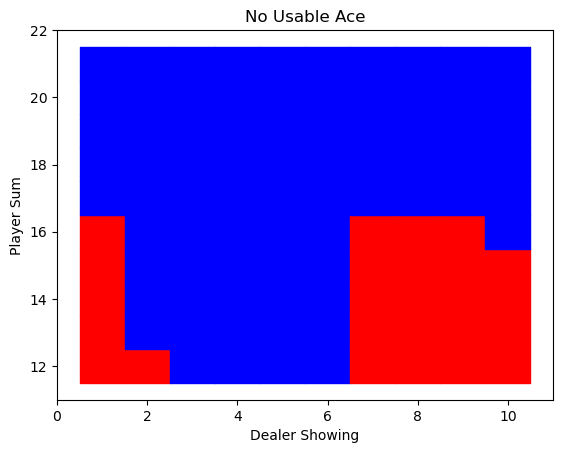

In [18]:
# The case when player has no usable ace
for k in range(1,11):
    for i in range(12,22):
        # Check if it's legal
        if not isclose(opt_policy[i,0,k,0] + opt_policy[i,0,k,1],1):
            print("Not a legal policy!")
            break
        if np.abs(opt_policy[i,0,k,1] - 1) < 0.5:
            # Hit
            plt.fill_between(x = [k - 0.5, k + 0.5],y1 = [i - 0.5,i - 0.5], y2 = [i + 0.5,i + 0.5],color='r')
        else:
            # Stand
            plt.fill_between(x = [k - 0.5, k + 0.5],y1 = [i - 0.5,i - 0.5], y2 = [i + 0.5,i + 0.5],color='b')
    
plt.title("No Usable Ace")
plt.xlabel("Dealer Showing")
plt.ylabel("Player Sum")
plt.show()

This is the optimal policy of Blackjack given that the dealer uses $17$-hit strategy. We remark that this optimal policy we derived is not exactly optimal but is very close to the optimal one shown in Barto-Sutton book. The interpretation of this optimal policy is left to the readers.

At last, let's check how well this optimal policy is working.

In [19]:
# Optimal policy derived from MC method
def opt_policy_strategy(state):
    if opt_policy[state[0],state[1],state[2],1] >= opt_policy[state[0],state[1],state[2],0]:
        return 1
    else:
        return 0

In [20]:
# Test the optimal policy
avg_reward = 0 
N_SIM = 100000
for _ in range(N_SIM):
    state_list, action_list, reward_list = simulate_blackjack(opt_policy_strategy)
    avg_reward += (reward_list[-1] / N_SIM)
print("Average reward:" + str(avg_reward))

Average reward:-0.12418999999998455


Given the policy of the dealer, the player has no way winning on average even if he sticks to the optimal policy.